In [1]:
import numpy as np
import matplotlib.pyplot as plt
import descent
from IPython.html.widgets import interact
from functools import partial
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib-1.5.dev1-py3.5-macosx-10.11-x86_64.egg/matplotlib/__init__.py:867: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import sklearn
from sklearn.datasets import make_regression

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


# Sparse linear regression

Again, we first generate a toy problem instance:

In [33]:
A, y, x = make_regression(n_samples=20, n_features=50, n_informative=5, coef=True)

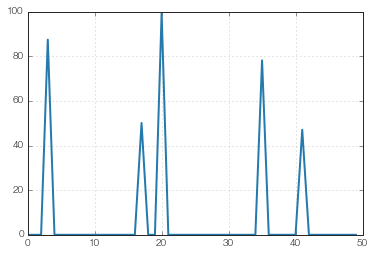

In [34]:
plt.plot(x)

## Least squares

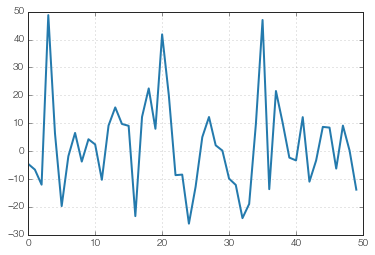

In [35]:
x_lsq = np.linalg.lstsq(A, y)[0]
plt.plot(x_lsq)

## Subgradient descent

In [36]:
def f_df_subg(x, penalty=0.5):
    obj = 0.5 * np.linalg.norm(A.dot(x) - y) + penalty * np.linalg.norm(x, 1)
    grad = A.T.dot(A).dot(x) - A.T.dot(y) + penalty * np.sign(x)
    return obj, grad

In [39]:
opt_subg = descent.sgd(f_df_subg, x_lsq, learning_rate=5e-3)
opt_subg.display.every = 1000
opt_subg.run(1e4)

+----------------+-----------------+----------------+
|Iteration       | Objective       | Runtime        |
+----------------+-----------------+----------------+
|              0 |          309.73 |             0 s|
|           1000 |             294 |      128.984 μs|
|           2000 |          280.89 |      138.998 μs|
|           3000 |          270.14 |      128.031 μs|
|           4000 |          260.74 |      173.092 μs|
|           5000 |          251.79 |      138.998 μs|
|           6000 |           243.4 |      196.934 μs|
|           7000 |          236.98 |       131.13 μs|
|           8000 |          233.13 |      135.899 μs|
|           9000 |          230.19 |      123.024 μs|
+----------------+-----------------+----------------+
➛ Final objective: 227.8768335547605
➛ Total runtime: 1.42597 s
➛ All done!



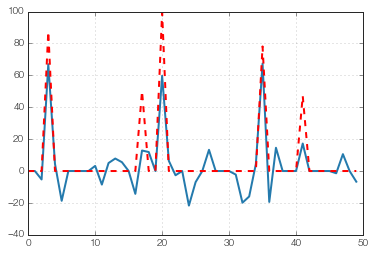

In [40]:
plt.plot(opt_subg.theta)
plt.plot(x, 'r--')

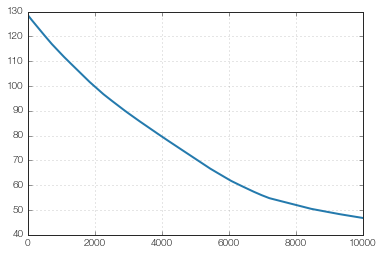

In [41]:
plt.plot(opt_subg.storage.get('obj') - f_df_subg(x)[0])

## ADMM

In [42]:
opt_admm = descent.admm(x_lsq, tau=(1., 1., 1.))
opt_admm.add('linsys', A, y)
opt_admm.add('sparse', 0.5)
opt_admm.display.every = 100
opt_admm.run(1000)

+----------------+-----------------+----------------+
|Iteration       | Objective       | Runtime        |
+----------------+-----------------+----------------+
|              0 |          670.07 |             0 s|
|            100 |          455.49 |      475.168 μs|
|            200 |          417.86 |       345.23 μs|
|            300 |          394.39 |      346.899 μs|
|            400 |          377.53 |      359.058 μs|
|            500 |          364.08 |      387.192 μs|
|            600 |          362.03 |      358.105 μs|
|            700 |          362.02 |      328.064 μs|
|            800 |          362.01 |      380.039 μs|
|            900 |          362.01 |      351.906 μs|
+----------------+-----------------+----------------+
➛ Final objective: 362.0103643401941
➛ Total runtime: 402.117 ms
➛ All done!



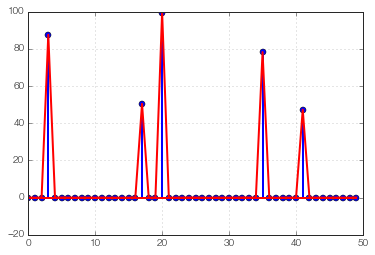

In [43]:
@interact(penalty=(0., 5., 0.5), maxiter=(50, 500, 50))
def solve_sparsereg(penalty=1., maxiter=500):
    opt_admm = descent.admm(x_lsq, tau=(2., 1.5, 1.5))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.run(maxiter)
    plt.stem(x)
    plt.plot(opt_admm.theta, 'r-')

In [68]:
def compare_algs(penalty=1., maxiter=500):
    
    
    # ADMM
    opt_admm = descent.admm(x_lsq, tau=(2., 1.5, 1.5))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.obj = lambda theta: f_df_subg(theta, penalty=penalty)[0]
    opt_admm.run(maxiter=maxiter)
#    plt.stem(x)
#    plt.plot(opt_admm.theta, 'r-')
    
    # Subgradient descent
    f_df = partial(f_df_subg, penalty=penalty)
    opt_subg = descent.sgd(f_df, x_lsq, learning_rate=1e-2)
    opt_subg.display = None
    opt_subg.run(maxiter=maxiter)
    
    return opt_admm, opt_subg

In [71]:
admm, subg = compare_algs(penalty=2., maxiter=2000)

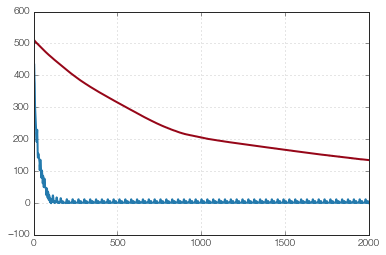

In [72]:
fstar = f_df_subg(x, penalty=2.)[0]
plt.plot(admm.storage.get('obj')-fstar)
plt.plot(subg.storage.get('obj')-fstar)